# Recurrent Neural Network

Mekanisme RNN menggunakan nilai hidden layer dari proses sebelumnya untuk menjadi input tambahan pada proses berikutnya. 

### Tugas
Tempelkan (concatenate) hidden layer yang didapatkan dari proses sebelumnya dengan input data berikutnya untuk menjadi input data yang baru untuk proses setelahnya. 

In [1]:
import torch

class RNN(torch.nn.Module):

    # you can also accept arguments in your model constructor
    def __init__(self, data_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        input_size = data_size + hidden_size

        self.i2h = torch.nn.Linear(input_size, hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, output_size)

    def forward(self, data, last_hidden):
        input_data = torch.cat((data, last_hidden), 1) # torch.cat(tensors, dimension)
        hidden = self.i2h(input_data)
        output = self.h2o(hidden)
        return hidden, output


rnn = RNN(50, 20, 10)

### Tugas

Hitung total akumulasi loss function untuk setiap proses dan lakukan backwardpropagation sekali saja

In [4]:
learning_rate = 0.005
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

batch_size = 16
timestep = 5

# Create some fake data

batch = torch.randn(batch_size, 50)
hidden = torch.zeros(batch_size, 20)
target = torch.zeros(batch_size, 10)

loss = 0
for t in range(timestep):
    # yes! you can reuse the same network several times,
    # sum up the losses, and call backward!
    hidden, output = rnn(batch, hidden)
    loss += loss_fn(output, target)
loss.backward()
optimizer.step()
print(loss)

    
    

tensor(0.5244, grad_fn=<AddBackward0>)


Data
==================

   Unduh data ini https://download.pytorch.org/tutorial/data.zip
   dan taruh pada folder yang sama dengan notebook ini

data ini berisi dictionary dari daftar nama dari tiap bahasa



In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


Sekarang kita mempunyai variabel ``category_lines``, dictionary yang memetakan setiap kategori bahasa ke sebuah daftar nama-nama. Kita juga melacak ``all_categories`` (daftar bahasa) dan ``n_categories`` untuk referensi.




In [6]:
print(category_lines['English'][:25])
print(category_lines['Spanish'][:25])
print(category_lines['Italian'][:25])
print(category_lines['German'][:25])
print(category_lines['French'][:25])
print(category_lines['Dutch'][:25])
print(category_lines['Russian'][:25])
print(all_categories)

['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel', 'Abraham', 'Abrahams', 'Abrams', 'Ackary', 'Ackroyd', 'Acton', 'Adair', 'Adam', 'Adams', 'Adamson', 'Adanet', 'Addams', 'Adderley', 'Addinall', 'Addis', 'Addison', 'Addley', 'Aderson', 'Adey', 'Adkins']
['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal', 'Abasolo', 'Abel', 'Abello', 'Aberquero', 'Abreu', 'Acosta', 'Agramunt', 'Aiza', 'Alamilla', 'Albert', 'Albuquerque', 'Aldana', 'Alfaro', 'Alvarado', 'Alvarez', 'Alves', 'Amador', 'Andreu', 'Antunez', 'Aqua']
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni', 'Abatescianni', 'Abba', 'Abbadelli', 'Abbascia', 'Abbatangelo', 'Abbatantuono', 'Abbate', 'Abbatelli', 'Abbaticchio', 'Abbiati', 'Abbracciabene', 'Abbracciabeni', 'Abelli', 'Abello', 'Abrami', 'Abramo', 'Acardi', 'Accardi', 'Accardo', 'Acciai']
['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles', 'Achterberg', 'Acker', 'Ackermann', 'Adam', 'Adenauer', 'Adler', 'Adlersflugel', 'Aeschelman', 'Albert', 'Albrecht', 'Aleshire', 'A

Mengubah Nama Menjadi Tensor
--------------------------

Sekarang kita memiliki susunan nama, kita perlu merubahnya menjadi tensor

Untuk merepresentasikan sebuah huruf, kita menggunakan "one-hot vector" dengan ukuran
``<1 x n_letters>``. Contoh: ``"b" = <0 1 0 0 0 ...>``.

Untuk membuat sebuah kata, kita menyatukan beberapa vektor menjadi matriks 2D
``<line_length x 1 x n_letters>``.

1 Dimensi tambahan karena PyTorch selalu menghitung dalam batch (kita menggunakan batch size=1)



In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('d'))
print(lineToTensor('data'))
print(lineToTensor('data').size())

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.

Membuat Network
====================

Modul RNN ini menggunakan 2 linear layers antara input dan hidden state dengan LogSoftmax pada output.

### Tugas
Tempel (concatenate) input data dan hidden layer, lalu gunakan combined data sebagai input untuk forward propagation pada hidden layer dan output layer



In [10]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = torch.nn.Linear(input_size + hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, input_data, hidden):
        combined = torch.cat((input_data, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
print(n_letters, n_hidden, n_categories)
rnn = RNN(n_letters, n_hidden, n_categories)
rnn

57 128 18


RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [11]:
input_data = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_data, hidden)
print(output)
print(next_hidden)

tensor([[-2.9364, -2.8777, -2.9105, -2.9736, -2.8928, -2.8078, -2.9748, -2.8890,
         -2.8881, -2.8564, -2.8808, -2.9288, -2.8886, -2.9140, -2.8348, -2.8412,
         -2.8691, -2.8786]], grad_fn=<LogSoftmaxBackward0>)
tensor([[ 0.0786, -0.0772, -0.0035,  0.1185,  0.1311, -0.0214,  0.0447, -0.0497,
         -0.0258,  0.0616, -0.0929, -0.0390, -0.0003,  0.0498, -0.0032, -0.0813,
         -0.0738,  0.0201,  0.0882, -0.0467, -0.0004,  0.0296,  0.0152, -0.0152,
         -0.0371,  0.0507,  0.0977,  0.0056,  0.0648,  0.0491,  0.0872, -0.0356,
         -0.0023,  0.0984, -0.0032, -0.1003, -0.1376,  0.0066,  0.0271,  0.1001,
          0.0873,  0.0156, -0.0282, -0.0034,  0.0180, -0.0189,  0.0725, -0.0199,
         -0.0182, -0.0033,  0.1285,  0.1047,  0.0063, -0.0151,  0.0632,  0.1144,
          0.0338, -0.0537, -0.0032,  0.1335, -0.0700, -0.0539, -0.1338, -0.1224,
         -0.0066, -0.0789, -0.0150,  0.1014,  0.0411, -0.0715, -0.0239,  0.0551,
          0.0003, -0.0367, -0.0256, -0.0697,  0.0

In [12]:
input_data = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_data[0], hidden)
print(output)
print(next_hidden)

tensor([[-2.9364, -2.8777, -2.9105, -2.9736, -2.8928, -2.8078, -2.9748, -2.8890,
         -2.8881, -2.8564, -2.8808, -2.9288, -2.8886, -2.9140, -2.8348, -2.8412,
         -2.8691, -2.8786]], grad_fn=<LogSoftmaxBackward0>)
tensor([[ 0.0786, -0.0772, -0.0035,  0.1185,  0.1311, -0.0214,  0.0447, -0.0497,
         -0.0258,  0.0616, -0.0929, -0.0390, -0.0003,  0.0498, -0.0032, -0.0813,
         -0.0738,  0.0201,  0.0882, -0.0467, -0.0004,  0.0296,  0.0152, -0.0152,
         -0.0371,  0.0507,  0.0977,  0.0056,  0.0648,  0.0491,  0.0872, -0.0356,
         -0.0023,  0.0984, -0.0032, -0.1003, -0.1376,  0.0066,  0.0271,  0.1001,
          0.0873,  0.0156, -0.0282, -0.0034,  0.0180, -0.0189,  0.0725, -0.0199,
         -0.0182, -0.0033,  0.1285,  0.1047,  0.0063, -0.0151,  0.0632,  0.1144,
          0.0338, -0.0537, -0.0032,  0.1335, -0.0700, -0.0539, -0.1338, -0.1224,
         -0.0066, -0.0789, -0.0150,  0.1014,  0.0411, -0.0715, -0.0239,  0.0551,
          0.0003, -0.0367, -0.0256, -0.0697,  0.0

As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Persiapan pelatihan
----------------------

Sebelum melatih, kita memerlukan fungsi tambahan. 
Fungsi ini untuk memperoleh kategori dari outputnya




In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 5)


Kita juga memerlukan fungsi untuk menghasilkan training data (nama dan bahasanya)




In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Hruska
category = Japanese / line = Okimoto
category = French / line = Fournier
category = Greek / line = Glynatsis
category = Korean / line = Li
category = Korean / line = Shon
category = Chinese / line = Huie
category = Vietnamese / line = Vinh
category = Portuguese / line = Ferreiro
category = Arabic / line = Sarraf


Melatih Network
--------------------
 
Untuk loss function akan menggunakan ``nn.NLLLoss`` karena lapisan terakhir RNN ini adalah ``nn.LogSoftmax``.




In [15]:
criterion = torch.nn.NLLLoss()

### Tugas

Setiap training loop akan melakukan:
- Membuat input dan target tensor
- Mengosongkan gradien 
- For loop setiap huruf untuk:
    - Membaca setiap huruf dan menyimpan hidden state untuk huruf berikutnya (Tugas)

- Membandingkan output akhir dengan kategori
- Backpropagation
- Menghasilkan output dan loss





In [16]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

### Tugas

print untuk setiap ``print_every``, lalu hitung loss rata-rata dan plot perubahan pada loss




5000 5% (0m 18s) 1.3652 Perugia / Czech ✗ (Italian)
10000 10% (0m 37s) 2.4046 Kennedy / English ✗ (Scottish)
15000 15% (0m 56s) 3.2353 Munro / Portuguese ✗ (Scottish)
20000 20% (1m 14s) 1.7694 Pitterman / Russian ✗ (Czech)
25000 25% (1m 33s) 0.4654 Eoin / Irish ✓
30000 30% (1m 52s) 0.3231 Mendelssohn / German ✓
35000 35% (2m 11s) 3.4670 Poulin / Russian ✗ (French)
40000 40% (2m 29s) 0.5429 Ruadhain / Irish ✓
45000 45% (2m 48s) 2.7502 Magalhaes / German ✗ (Portuguese)
50000 50% (3m 7s) 0.7953 Mclean / Scottish ✓
55000 55% (3m 27s) 2.8162 Munro / Italian ✗ (Scottish)
60000 60% (3m 46s) 6.4726 Researcher / Dutch ✗ (Russian)
65000 65% (4m 5s) 0.7224 Melo / Portuguese ✓
70000 70% (4m 25s) 0.3991 Ashida / Japanese ✓
75000 75% (4m 43s) 0.6527 Banos / Greek ✓
80000 80% (5m 2s) 0.0824 Zientek / Polish ✓
85000 85% (5m 21s) 0.2941 Kasprzak / Polish ✓
90000 90% (5m 39s) 0.9362 Tsang / Chinese ✓
95000 95% (5m 58s) 2.9713 Mojjis / Greek ✗ (Czech)
100000 100% (6m 17s) 0.9956 Ruan / Chinese ✓


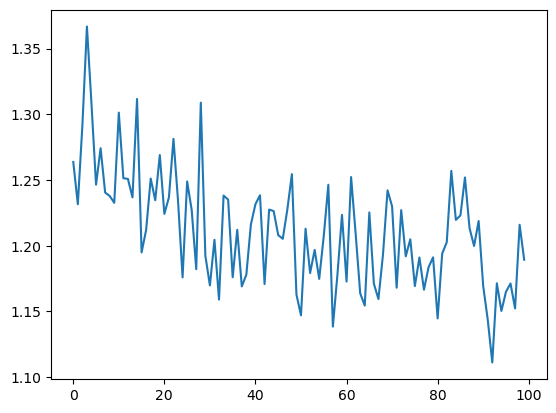

In [22]:
import time
import math
import matplotlib.pyplot as plt

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plt.figure()
plt.plot(all_losses)

Evaluasi
======================

Untuk melihat performa network pada kategori yang berbeda, kita akan membuat sebuah confusion matrix, sebagai indikator untuk setiap input bahasa (baris), bahasa manakah yang ditebak (kolom). Untuk menghitung confusion matrix, sampel akan melewati network melalui fungsi ``evaluate()``, dimana identik dengan fungsi ``train()`` kecuali bagian backprop.




C:\Users\cleve\AppData\Local\Temp\ipykernel_21652\2101746829.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\cleve\AppData\Local\Temp\ipykernel_21652\2101746829.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


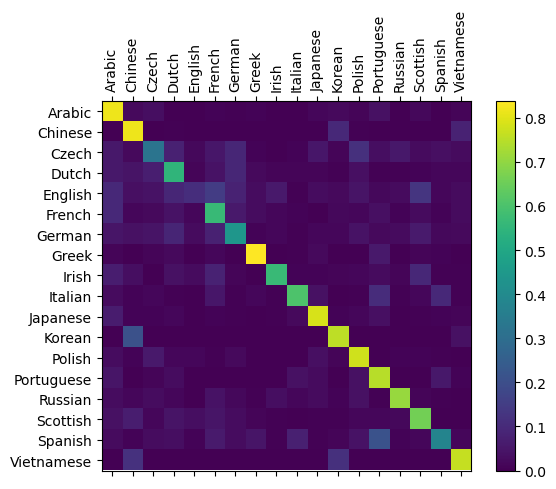

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Prediksi pada Input Apapun
---------------------




In [24]:
def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Sanga')
predict('Yozef')
predict('Hendrik')
predict('Bambang')



> Sanga
(-1.18) Japanese
(-1.58) Arabic
(-1.98) Portuguese
(-2.05) Polish
(-2.17) Spanish

> Yozef
(-0.36) Polish
(-2.74) Czech
(-2.81) German
(-3.24) Russian
(-3.36) Dutch

> Hendrik
(-0.55) Czech
(-1.41) Polish
(-3.23) Dutch
(-3.27) German
(-3.63) English

> Bambang
(-0.73) Polish
(-1.88) German
(-2.66) English
(-3.18) French
(-3.19) Italian


### Tugas

Coba modifikasi struktur network, misalnya menambah beberapa lapisan linear
    




### 2 hidden layers

In [25]:
### Buatlah kelas RNN dengan 2 hidden layers

5000 5% (0m 19s) 0.1148 Son / Korean ✓
10000 10% (0m 38s) 1.9779 Kohl / Chinese ✗ (German)
15000 15% (0m 57s) 2.4752 Ashford / Arabic ✗ (English)
20000 20% (1m 16s) 0.4669 Mcnulty / English ✓
25000 25% (1m 35s) 0.1310 An / Vietnamese ✓
30000 30% (1m 54s) 1.8947 Gabrisova / Italian ✗ (Czech)
35000 35% (2m 13s) 0.1540 Aggi / Italian ✓
40000 40% (2m 31s) 1.8048 Core / French ✗ (English)
45000 45% (2m 50s) 0.4935 Liu / Chinese ✓
50000 50% (3m 9s) 4.6884 Degarmo / Italian ✗ (French)
55000 55% (3m 27s) 0.2711 Ustyuzhanin / Russian ✓
60000 60% (3m 46s) 2.2607 Kubin / Russian ✗ (Czech)
65000 65% (4m 5s) 2.1938 Kubin / Russian ✗ (Czech)
70000 70% (4m 23s) 4.8909 Makricosta / Czech ✗ (Greek)
75000 75% (4m 42s) 0.1036 Pontecorvo / Italian ✓
80000 80% (5m 1s) 1.7549 San / Chinese ✗ (Korean)
85000 85% (5m 20s) 1.9000 Basurto / Portuguese ✗ (Spanish)
90000 90% (5m 38s) 0.2434 Palmeiro / Portuguese ✓
95000 95% (5m 57s) 2.0287 Sai / Chinese ✗ (Vietnamese)
100000 100% (6m 16s) 2.3144 Gagentorn / Englis

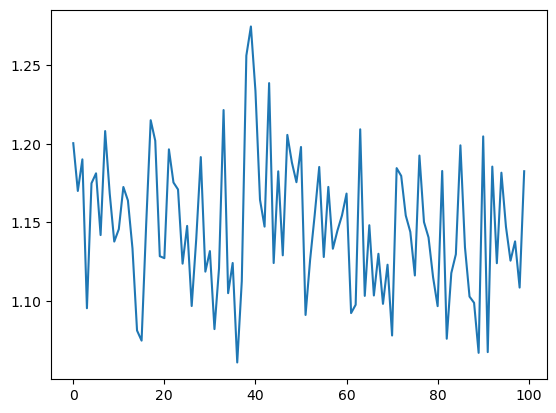

In [26]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)        
        

C:\Users\cleve\AppData\Local\Temp\ipykernel_21652\3441438691.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\cleve\AppData\Local\Temp\ipykernel_21652\3441438691.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


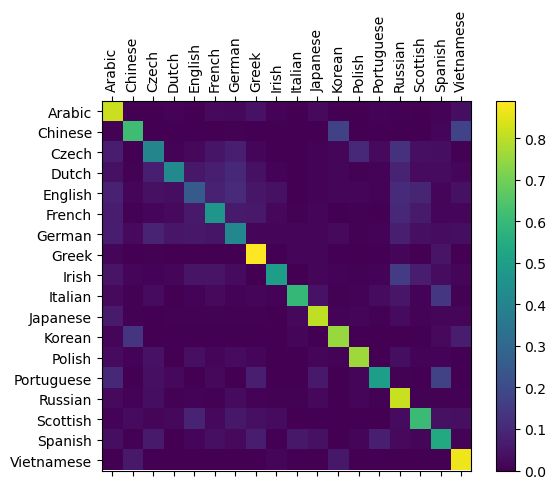


> Sanga
(-0.62) Spanish
(-1.93) Polish
(-2.31) Japanese
(-2.66) Portuguese
(-3.21) Arabic

> Yozef
(-0.40) Polish
(-2.43) Spanish
(-2.85) Russian
(-3.42) German
(-3.57) Arabic

> Hendrik
(-0.34) Czech
(-1.78) Russian
(-3.06) Polish
(-3.51) English
(-4.12) German

> Bambang
(-1.09) Polish
(-1.76) Vietnamese
(-2.02) German
(-2.35) Russian
(-2.57) Chinese


In [27]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Sanga')
predict('Yozef')
predict('Hendrik')
predict('Bambang')


### 3 hidden layers

In [28]:
### Buatlah kelas RNN dengan 3 hidden layers

5000 5% (0m 18s) 0.2513 Didenko / Russian ✓
10000 10% (0m 37s) 0.0621 Moghadam / Arabic ✓
15000 15% (0m 56s) 0.0045 Tselovalnov / Russian ✓
20000 20% (1m 14s) 0.1662 Campbell / Scottish ✓
25000 25% (1m 33s) 0.1663 Cabrera / Spanish ✓
30000 30% (1m 52s) 2.7150 Arce / German ✗ (Spanish)
35000 35% (2m 10s) 0.0025 Karahalios / Greek ✓
40000 40% (2m 29s) 3.0246 Guillory / English ✗ (French)
45000 45% (2m 48s) 0.4822 Raghailligh / Irish ✓
50000 50% (3m 7s) 0.7026 Aliprandi / Italian ✓
55000 55% (3m 26s) nan Kouba / Arabic ✗ (Czech)
60000 60% (3m 45s) nan Mitchell / Arabic ✗ (Scottish)
65000 65% (4m 4s) nan Naser / Arabic ✓
70000 70% (4m 23s) nan Zientek / Arabic ✗ (Polish)
75000 75% (4m 42s) nan Sniegowski / Arabic ✗ (Polish)
80000 80% (5m 1s) nan Dinh / Arabic ✗ (Vietnamese)
85000 85% (5m 19s) nan Kyubei / Arabic ✗ (Japanese)
90000 90% (5m 38s) nan Prinz / Arabic ✗ (German)
95000 95% (5m 57s) nan Almasi / Arabic ✓
100000 100% (6m 16s) nan Bradan / Arabic ✗ (Irish)


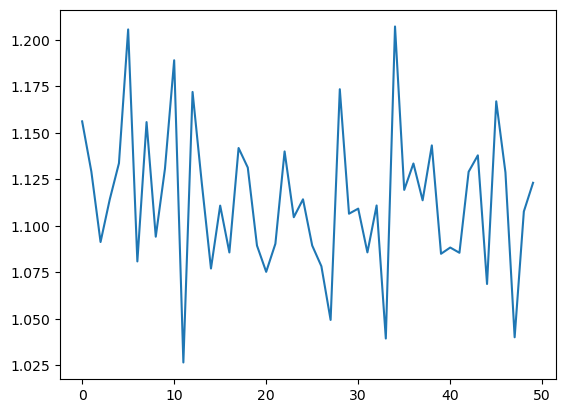

In [29]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)        
        

C:\Users\cleve\AppData\Local\Temp\ipykernel_21652\3441438691.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\cleve\AppData\Local\Temp\ipykernel_21652\3441438691.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


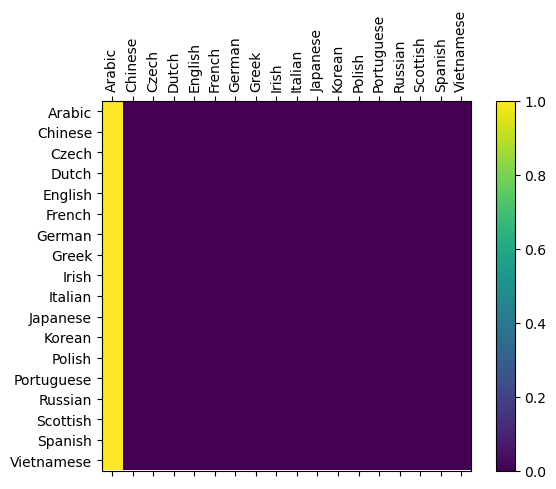


> Sanga
(nan) Arabic
(nan) Chinese
(nan) Czech
(nan) Dutch
(nan) English

> Yozef
(nan) Arabic
(nan) Chinese
(nan) Czech
(nan) Dutch
(nan) English

> Hendrik
(nan) Arabic
(nan) Chinese
(nan) Czech
(nan) Dutch
(nan) English

> Bambang
(nan) Arabic
(nan) Chinese
(nan) Czech
(nan) Dutch
(nan) English


In [30]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Sanga')
predict('Yozef')
predict('Hendrik')
predict('Bambang')
